# State estimation with unknown $\mathbf{A}$ and $\gamma$
## Model specification
$$p(\mathbf{x, y, a, \gamma}) = p(\mathbf{x}_0)p(\mathbf{a})p(\gamma_x)p(\gamma_y)\prod_{n=1}^Np(\mathbf{x}_n|\mathbf{x}_{n-1}, \mathbf{a, \gamma_x})p(y_n|\mathbf{x}_n, \gamma_y)$$

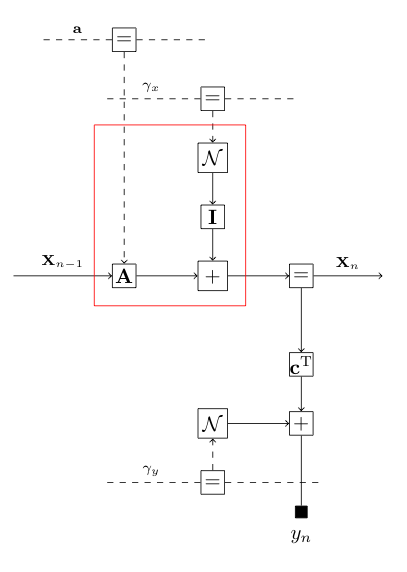

In [1]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$, the precision  of the driving noise $\gamma_x$ and the states $\mathbf{x}_n$, $\mathbf{x}_{n-1}$.

In [2]:
using ProgressMeter
using Revise
using ForneyLab
include("../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [3]:
ARorder = 2 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# Coefs and real states
coefs, x = generate_data(10000, ARorder, 1, noise_variance=0.1)
# Observations
measurement_noise = 1.0
y = [xi[1] + sqrt(measurement_noise)*randn() for xi in x[2:end]];

9999-element Array{Float64,1}:
  1.2589173398620908 
  1.9292067104056732 
 -2.112522384450297  
 -0.18684957214218412
 -1.6340746825370405 
  0.3502971660002693 
 -0.1411826935208758 
 -0.15584994304119515
 -2.363171970273849  
 -0.225249300020883  
  2.1281268420312607 
 -1.434007071723117  
 -0.8933819514763097 
  ⋮                  
  0.3196882103110844 
  2.009414412430773  
 -0.9053585728541227 
  0.245136904062878  
  1.0458004530579994 
 -0.41688329462233353
  0.6281108486566437 
 -0.06628106877302142
  0.45943980000529183
 -2.126329674277401  
  0.1724738167001318 
  0.26085385801479355

In [5]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_x_t
@RV w_x_t
@RV a_w_t
@RV b_w_t
@RV m_a_t
@RV w_a_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w_t, b_w_t)
@RV x_t ~ GaussianMeanPrecision(m_x_t, w_x_t)
Autoregression(x_t, x_t_prev, a, w)
@RV n ~ GaussianMeanPrecision(0.0, 1.0)
c = zeros(ARorder); c[1] = 1.0
@RV y_t = dot(c, x_t) + n

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_x_t, :m_x_t, dims=(ARorder,))
placeholder(w_x_t, :w_x_t, dims=(ARorder, ARorder))
placeholder(a_w_t, :a_w_t)
placeholder(b_w_t, :b_w_t)
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(y_t, :y_t);

Variable(:y_t, Edges:
Edge belonging to variable y_t: ( addition_1.i[out] )----( placeholder_y_t.i[out] ).
)

In [6]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t_prev, x_t, w, ids=[:A, :X_t_prev, :X_t, :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [7]:
# Define values for prior statistics
m_x_prev_0 = 0.0*rand(ARorder)
w_x_prev_0 = (tiny*diagAR(ARorder))
m_x_0 = 0.0*rand(ARorder)
w_x_0 = (tiny*diagAR(ARorder))
a_w_0 = tiny
b_w_0 = huge
m_a_0 =  1.0*rand(ARorder)
w_a_0 =  (tiny*diagAR(ARorder));

10×10 Array{Float64,2}:
 1.0e-12  0.0      0.0      0.0      …  0.0      0.0      0.0      0.0    
 0.0      1.0e-12  0.0      0.0         0.0      0.0      0.0      0.0    
 0.0      0.0      1.0e-12  0.0         0.0      0.0      0.0      0.0    
 0.0      0.0      0.0      1.0e-12     0.0      0.0      0.0      0.0    
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      0.0    
 0.0      0.0      0.0      0.0      …  0.0      0.0      0.0      0.0    
 0.0      0.0      0.0      0.0         1.0e-12  0.0      0.0      0.0    
 0.0      0.0      0.0      0.0         0.0      1.0e-12  0.0      0.0    
 0.0      0.0      0.0      0.0         0.0      0.0      1.0e-12  0.0    
 0.0      0.0      0.0      0.0         0.0      0.0      0.0      1.0e-12

In [8]:
# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(x))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(x))
m_x = Vector{Vector{Float64}}(undef, length(x))
w_x = Vector{Array{Float64, 2}}(undef, length(x))
a_w = Vector{Float64}(undef, length(x))
b_w = Vector{Float64}(undef, length(x))
m_a = Vector{Vector{Float64}}(undef, length(x))
w_a = Vector{Array{Float64, 2}}(undef, length(x))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_x_t_min = m_x_0
w_x_t_min = w_x_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [10]:
marginals = Dict()
n_its = 10
p = Progress(length(y), 1, "Observed ")
for t = 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_min, w=w_x_t_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    global m_x_t_prev_min, w_x_t_prev_min, m_x_t_min, w_x_t_min,
           a_w_t_min, b_w_t_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:y_t   => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :m_x_t => m_x_t_min,
                    :w_x_t => w_x_t_min,
                    :a_w_t => a_w_t_min,
                    :b_w_t => b_w_t_min)

        stepA!(data, marginals)
        stepW!(data, marginals)
        stepX_t!(data, marginals)
        stepX_t_prev!(data, marginals)
    end

    m_a[t] = unsafeMean(marginals[:a])
    w_a[t] = unsafePrecision(marginals[:a])
    m_x[t] = unsafeMean(marginals[:x_t])
    w_x[t] = unsafePrecision(marginals[:x_t])
    m_x_prev[t] = unsafeMean(marginals[:x_t_prev])
    w_x_prev[t] = unsafePrecision(marginals[:x_t_prev])
    a_w[t] = marginals[:w].params[:a]
    b_w[t] = marginals[:w].params[:b]
    # Store to buffer
    m_a_t_min = m_a[t]
    w_a_t_min = w_a[t]
    m_x_t_prev_min = m_x_prev[t]
    w_x_t_prev_min = w_x_prev[t]
    m_x_t_min = m_x[t]
    w_x_t_min = w_x[t]
    a_w_t_min = a_w[t]
    b_w_t_min = b_w[t]
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:32


In [11]:
predicted = [x[1] for (t, x) in enumerate(m_x[1:end-1])]
noise = [y[1] for y in y[1:end]]
actual = [x[1] for x in x[2:end]]
println("Δ(predicted, noise)=", mse(predicted, noise))
println("Δ(predicted, actual)=", mse(predicted, actual))

Δ(predicted, noise)=1.200954700615586
Δ(predicted, actual)=0.20110931335775262


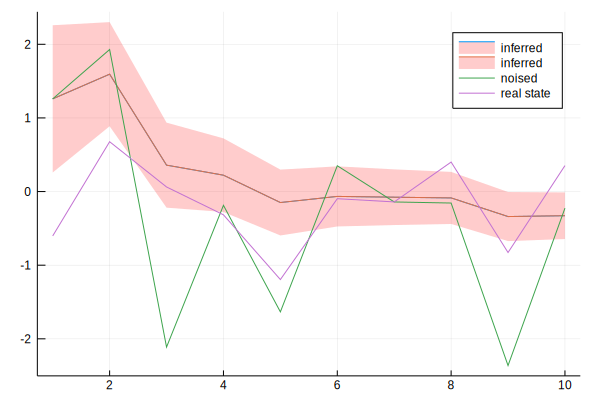

In [13]:
v_x = [v_x[1]^-1 for v_x in w_x[1:end-1]] # variances of estimated state

using Plots
upto = 10 # limit for building a graph
scale = 1.0 # scale for the variance
plot([predicted[1:upto], predicted[1:upto]], fillrange=[predicted[1:upto] -
      scale .* sqrt.(v_x[1:upto]), predicted[1:upto] +
      scale .* sqrt.(v_x[1:upto])],
      fillalpha = 0.2,
      fillcolor = :red,
      label=["inferred", "inferred"])
plot!(noise[1:upto], label="noised")
plot!(actual[1:upto], label="real state")